# RetinaNet을 사용한 물체 감지

**Author:** [Srihari Humbarwadi](https://twitter.com/srihari_rh)<br>
**Date created:** 2020/05/17<br>
**Last modified:** 2020/07/14<br>
**Description:** RetinaNet 구현: 조밀한 물체 감지를 위한 초점 손실.

## 소개

컴퓨터에서 물체 감지는 매우 중요한 문제 전망. <br>
여기에서 모델은 이미지에 있는 개체를 지역화하는 동시에 다른 범주로 분류하는 작업을 수행합니다.<br>
물체 감지 모델은 "1단계"와 "2단계" 감지기로 크게 분류할 수 있습니다. <br>
2단계 검출기는 종종 더 정확하지만 속도가 느려집니다. <br>
여기 이 예에서는 정확하고 빠르게 실행되는 인기 있는 단일 단계 감지기인 RetinaNet을 구현합니다.<br>
RetinaNet은 특성 피라미드 네트워크를 사용하여 여러 스케일에서 객체를 효율적으로 감지하고 새로운 손실인 초점 손실 기능을 도입하여 극심한 전경-배경 클래스 불균형 문제를 완화합니다.

**참조:**

- [RetinaNet Paper](https://arxiv.org/abs/1708.02002)
- [Feature Pyramid Network Paper](https://arxiv.org/abs/1612.03144)

In [478]:

import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


## COCO2017 데이터 세트 다운로드

약 118,000개의 이미지가 있는 전체 COCO2017 데이터 세트에 대한 교육에는 많은 시간이 걸리므로 이 예에서는 교육에 ~500개 이미지의 더 작은 하위 집합을 사용합니다.

In [479]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip")
keras.utils.get_file(filename, url)


with zipfile.ZipFile("data.zip", "r") as z_fp:
    z_fp.extractall("./")


## 유틸리티 기능 구현

경계 상자는 여러 가지 방법으로 나타낼 수 있으며 가장 일반적인 형식은 다음과 같습니다.

- 모서리 좌표 저장 `[xmin, ymin, xmax, ymax]`
- 중심 좌표와 상자 치수 저장
`[x, y, 너비, 높이]`

두 형식이 모두 필요하므로 변환 기능을 구현할 것입니다.
형식 사이.

In [480]:

def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.

    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.

    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


In [481]:
boxes = tf.constant([[100,200,300,400]],dtype="float32")
# print(swap_xy(boxes))
boxes = convert_to_xywh(boxes)  # (200,300,200,200)
print(boxes)
boxes = convert_to_corners(boxes)
print(boxes)

tf.Tensor([[200. 300. 200. 200.]], shape=(1, 4), dtype=float32)
tf.Tensor([[100. 200. 300. 400.]], shape=(1, 4), dtype=float32)


## IOU(합집합에 대한 쌍별 교차) 계산

예제의 뒷부분에서 볼 수 있듯이 중첩 정도에 따라 고정 상자에 정답 상자를 할당합니다. <br>
이를 위해서는 모든 앵커 박스와 정답 박스 쌍 사이의 IOU(Intersection Over Union)를 계산해야 합니다.

In [482]:

def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax


In [483]:
boxes1 = tf.constant([[100,200,300,400]],dtype="float32")
boxes2 = tf.constant([[400,200,600,400]],dtype="float32")

boxes1 = convert_to_xywh(boxes1)  
boxes2 = convert_to_xywh(boxes2) 

ratio = compute_iou(boxes1, boxes2)
print(ratio)

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


## 앵커 생성기 구현

앵커 상자는 모델이 개체의 경계 상자를 예측하는 데 사용하는 고정 크기 상자입니다. 객체 중심 위치와 앵커 상자 중심 사이의 오프셋을 회귀하여 이를 수행한 다음 앵커 상자의 너비와 높이를 사용하여 객체의 상대적인 크기를 예측합니다. RetinaNet의 경우 지정된 특성 맵의 각 위치에는 9개의 앵커 상자(3개의 축척 및 3개의 비율)가 있습니다.

In [484]:
rx = (tf.range(2, dtype=tf.float32) + 0.5)*8
ry = (tf.range(2, dtype=tf.float32) + 0.5)*8
centers = tf.meshgrid(rx, ry)
print(centers)
centers = tf.stack(centers, axis=-1)
print(centers)

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 4., 12.],
       [ 4., 12.]], dtype=float32)>, <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 4.,  4.],
       [12., 12.]], dtype=float32)>]
tf.Tensor(
[[[ 4.  4.]
  [12.  4.]]

 [[ 4. 12.]
  [12. 12.]]], shape=(2, 2, 2), dtype=float32)


In [485]:

class AnchorBox:
    """Generates anchor boxes.

    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.

    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
#         print(self.aspect_ratios)
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
#         print(self.scales)
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
#         print(self._num_anchors)
        self._strides = [2 ** i for i in range(3, 8)]
#         print(self._strides)
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
#         print(self._areas)
        self._anchor_dims = self._compute_dims()
#         print(self._anchor_dims)

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:  # 5회전
            anchor_dims = []
            for ratio in self.aspect_ratios:  # 3회전
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
#                 print(dims)
                for scale in self.scales:   #  3회전
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level

        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.

        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
#         print(rx)
#         print(ry)
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
#         print(centers)
#         print(centers.shape)
        centers = tf.expand_dims(centers, axis=-2)
#         print(centers.shape)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
#         print(centers)
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
#         print(dims)
#         print(dims.shape)
        anchors = tf.concat([centers, dims], axis=-1)
#         print(anchors)
#         print(feature_height * feature_width * self._num_anchors)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.

        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.

        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
#         for i in anchors:
#             print(i.shape)
        return tf.concat(anchors, axis=0)


In [497]:
a = AnchorBox()
# print(a._anchor_dims)
ret = a.get_anchors(100,100)

# print(ret)
print(ret.shape)

(2151, 4)


## 데이터 전처리

이미지 사전 처리에는 두 단계가 포함됩니다.

- 이미지 크기 조정: 이미지는 가장 짧은 크기가 800픽셀과 같도록 크기가 조정됩니다. 크기 조정 후 이미지의 가장 긴 면이 1333픽셀을 초과하면 이미지가 가장 긴 크기가 이제 1333픽셀로 제한되도록 크기가 조정됩니다.
- 증강 적용: 임의 스케일 지터링 및 임의 수평 뒤집기가 이미지에 적용된 유일한 증강입니다.

이미지와 함께 경계 상자의 크기가 조정되고 필요한 경우 뒤집힙니다.

In [487]:

def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.

    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes


def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    """Resizes and pads image while preserving aspect ratio.

    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.

    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(sample):
    print("preprocess_data()")
    """Applies preprocessing step to a single sample

    Arguments:
      sample: A dict representing a single training sample.

    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
    image = sample["image"]
    print(image.shape)
    print(sample["objects"]["bbox"])
    bbox = swap_xy(sample["objects"]["bbox"])
    print(bbox)
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)
    print(class_id)

    image, bbox = random_flip_horizontal(image, bbox)
    print(bbox)
    image, image_shape, _ = resize_and_pad_image(image)
    print(image.shape)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id


### 전처리 테스트

In [488]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

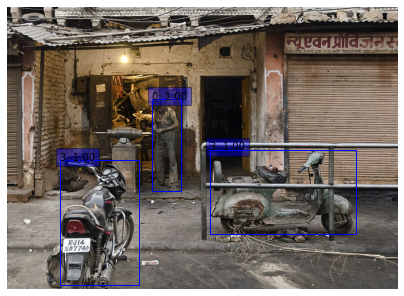

preprocess_data()
(462, 640, 3)
tf.Tensor(
[[0.54380953 0.13464062 0.98651516 0.33742186]
 [0.50707793 0.517875   0.8044805  0.891125  ]
 [0.3264935  0.36971876 0.65203464 0.4431875 ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[0.13464062 0.54380953 0.33742186 0.98651516]
 [0.517875   0.50707793 0.891125   0.8044805 ]
 [0.36971876 0.3264935  0.4431875  0.65203464]], shape=(3, 4), dtype=float32)
tf.Tensor([3 3 0], shape=(3,), dtype=int32)
tf.Tensor(
[[0.13464062 0.54380953 0.33742186 0.98651516]
 [0.517875   0.50707793 0.891125   0.8044805 ]
 [0.36971876 0.3264935  0.4431875  0.65203464]], shape=(3, 4), dtype=float32)
(768, 1024, 3)


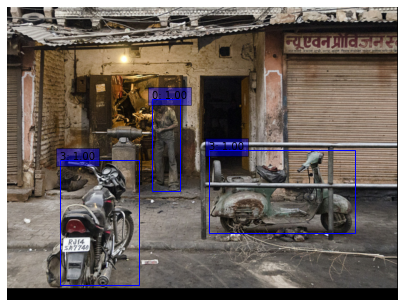

In [489]:
for  data in train_dataset.take(1):
#     print(data)
    image = data["image"]
    image_shape = image.shape
#     print(image_shape)
#     print(data["objects"]["bbox"])

    bbox = swap_xy(data["objects"]["bbox"])
#     print(bbox)
    scores =  tf.constant([1.0,1.0,1.0])
    bbox = tf.stack(
    [
        bbox[:, 0] * image_shape[1],
        bbox[:, 1] * image_shape[0],
        bbox[:, 2] * image_shape[1],
        bbox[:, 3] * image_shape[0],
    ],
    axis=-1,
    )
#     print(bbox)
    visualize_detections(data["image"], bbox, data["objects"]["label"], scores )
    
    image, bbox, class_id = preprocess_data(data)
    bbox = convert_to_corners(bbox) 
    visualize_detections(image, bbox, class_id, scores )
    

## 인코딩 레이블

경계 상자와 클래스 ID로 구성된 원시 레이블은 다음과 같아야 합니다.
훈련 대상으로 변경되었습니다. 이 변환은 다음으로 구성됩니다.
다음 단계:

- 주어진 이미지 치수에 대한 앵커 박스 생성
- 앵커 박스에 ground truth box 할당
- 객체가 할당되지 않은 앵커 박스는 IOU에 따라 백그라운드 클래스가 할당되거나 무시됩니다.
- 앵커박스를 이용한 분류 및 회귀 타겟 생성

In [544]:

class LabelEncoder:
    """Transforms the raw labels into targets for training.

    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.

    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """Matches ground truth boxes to anchor boxes based on IOU.

        1. Calculates the pairwise IOU for the M `anchor_boxes` and N `gt_boxes`
          to get a `(M, N)` shaped matrix.
        2. The ground truth box with the maximum IOU in each row is assigned to
          the anchor box provided the IOU is greater than `match_iou`.
        3. If the maximum IOU in a row is less than `ignore_iou`, the anchor
          box is assigned with the background class.
        4. The remaining anchor boxes that do not have any class assigned are
          ignored during training.

        Arguments:
          anchor_boxes: A float tensor with the shape `(total_anchors, 4)`
            representing all the anchor boxes for a given input image shape,
            where each anchor box is of the format `[x, y, width, height]`.
          gt_boxes: A float tensor with shape `(num_objects, 4)` representing
            the ground truth boxes, where each box is of the format
            `[x, y, width, height]`.
          match_iou: A float value representing the minimum IOU threshold for
            determining if a ground truth box can be assigned to an anchor box.
          ignore_iou: A float value representing the IOU threshold under which
            an anchor box is assigned to the background class.

        Returns:
          matched_gt_idx: Index of the matched object
          positive_mask: A mask for anchor boxes that have been assigned ground
            truth boxes.
          ignore_mask: A mask for anchor boxes that need to by ignored during
            training
        """
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        print(positive_mask)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        print('_encode_sample()')
        print(image_shape)
        print(gt_boxes)
        print(cls_ids)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        print(anchor_boxes.shape)
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        print(matched_gt_boxes)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        print(box_target.shape)
        print(matched_gt_idx)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Creates box and classification targets for a batch"""
        print('encode_batch()')
        images_shape = tf.shape(batch_images)
        print(images_shape)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()


### 라벨 인코더 테스트

In [545]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

In [550]:
label_encoder = LabelEncoder()
for  data in train_dataset.take(1):
#     print(data)
    batch_images = data['image']
    print(batch_images.shape)
    batch_images = tf.expand_dims(batch_images, axis=0)
    print(batch_images.shape)
    gt_boxes = data['objects']['bbox']
    gt_boxes = tf.expand_dims(gt_boxes, axis=0)
    print(gt_boxes.shape)
    cls_ids = data['objects']['label']
    cls_ids = tf.expand_dims(cls_ids, axis=0)
    print(cls_ids.shape)
    batch_images, labels = label_encoder.encode_batch(batch_images, gt_boxes, cls_ids)
    print(labels.shape)
#     print(labels)
    for i in labels[0]:
        if i[4] > -1 :
            print(i)

(462, 640, 3)
(1, 462, 640, 3)
(1, 3, 4)
(1, 3)
encode_batch()
tf.Tensor([  1 462 640   3], shape=(4,), dtype=int32)
_encode_sample()
tf.Tensor([  1 462 640   3], shape=(4,), dtype=int32)
tf.Tensor(
[[0.54380953 0.13464062 0.98651516 0.33742186]
 [0.50707793 0.517875   0.8044805  0.891125  ]
 [0.3264935  0.36971876 0.65203464 0.4431875 ]], shape=(3, 4), dtype=float32)
tf.Tensor([3 3 0], shape=(3,), dtype=int64)
(55800, 4)
tf.Tensor([False False False ... False False False], shape=(55800,), dtype=bool)
tf.Tensor(
[[0.50707793 0.517875   0.8044805  0.891125  ]
 [0.50707793 0.517875   0.8044805  0.891125  ]
 [0.50707793 0.517875   0.8044805  0.891125  ]
 ...
 [0.54380953 0.13464062 0.98651516 0.33742186]
 [0.54380953 0.13464062 0.98651516 0.33742186]
 [0.54380953 0.13464062 0.98651516 0.33742186]], shape=(55800, 4), dtype=float32)
(55800, 4)
tf.Tensor([1 1 1 ... 0 0 0], shape=(55800,), dtype=int64)
(1, 55800, 5)


In [551]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

In [552]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)

preprocess_data()
(None, None, 3)
Tensor("args_4:0", shape=(None, 4), dtype=float32)
Tensor("stack:0", shape=(None, 4), dtype=float32)
Tensor("Cast:0", shape=(None,), dtype=int32)
Tensor("cond/Identity:0", shape=(None, 4), dtype=float32)
(None, None, 3)


In [553]:
label_encoder = LabelEncoder()
for  data in train_dataset.take(1):
    batch_images = data[0]
    gt_boxes = data[1]
    cls_ids = data[2]
    batch_images, labels = label_encoder.encode_batch(batch_images, gt_boxes, cls_ids)
    print(labels.shape)
#     print(labels)
    for i in labels[0]:
        if i[4] > -1 :
            print(i)

encode_batch()
tf.Tensor([   1 1024 1408    3], shape=(4,), dtype=int32)
_encode_sample()
tf.Tensor([   1 1024 1408    3], shape=(4,), dtype=int32)
tf.Tensor(
[[302.29626 707.4225  259.71143 409.2986 ]
 [902.28613 606.29346 478.03876 274.96027]
 [520.56354 452.34375  94.09482 300.9755 ]], shape=(3, 4), dtype=float32)
tf.Tensor([3 3 0], shape=(3,), dtype=int32)
(270072, 4)
tf.Tensor([False False False ... False False False], shape=(270072,), dtype=bool)
tf.Tensor(
[[302.29626 707.4225  259.71143 409.2986 ]
 [302.29626 707.4225  259.71143 409.2986 ]
 [302.29626 707.4225  259.71143 409.2986 ]
 ...
 [302.29626 707.4225  259.71143 409.2986 ]
 [902.28613 606.29346 478.03876 274.96027]
 [902.28613 606.29346 478.03876 274.96027]], shape=(270072, 4), dtype=float32)
(270072, 4)
tf.Tensor([0 0 0 ... 0 1 1], shape=(270072,), dtype=int64)
(1, 270072, 5)
tf.Tensor([-0.8216208  2.891611   0.1942318  2.5421252  0.       ], shape=(5,), dtype=float32)
tf.Tensor([-0.6521208   2.295073   -0.96101356  1.38

## ResNet50 백본 구축

RetinaNet은 기능 피라미드 네트워크를 구성하는 ResNet 기반 백본을 사용합니다. 이 예에서 우리는 ResNet50을 백본으로 사용하고 보폭 8, 16 및 32에서 특성 맵을 반환합니다.

In [554]:

def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )


## Feature Pyramid Network를 커스텀 레이어로 구축하기

In [556]:

class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


### 특성 피라미드 네트워크 테스트

In [557]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

In [558]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)

preprocess_data()
(None, None, 3)
Tensor("args_4:0", shape=(None, 4), dtype=float32)
Tensor("stack:0", shape=(None, 4), dtype=float32)
Tensor("Cast:0", shape=(None,), dtype=int32)
Tensor("cond/Identity:0", shape=(None, 4), dtype=float32)
(None, None, 3)


In [559]:
fpn = FeaturePyramid()
for  data in train_dataset.take(1):
    print(data[0].shape)
    ret = fpn(data[0])
    for i in ret:
        print(i.shape)

(1, 1024, 1408, 3)
(1, 128, 176, 256)
(1, 64, 88, 256)
(1, 32, 44, 256)
(1, 16, 22, 256)
(1, 8, 11, 256)


## 분류 및 상자 회귀 헤드 구축.
RetinaNet 모델에는 경계 상자 회귀 및 개체에 대한 클래스 확률 예측을 위한 별도의 헤드가 있습니다. 이 헤드는 특성 피라미드의 모든 특성 맵 간에 공유됩니다.

In [560]:

def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.

    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.

    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head


## 서브클래싱된 모델을 사용하여 RetinaNet 빌드

In [561]:

class RetinaNet(keras.Model):
    """A subclassed Keras model implementing the RetinaNet architecture.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, num_classes, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        print('RetinaNet.call', image.shape)
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        print('N=',N)
        cls_outputs = []
        box_outputs = []
        for feature in features:
            print(feature.shape)
            print(self.box_head(feature).shape)
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        print('cls_outputs.shape=',cls_outputs.shape)
        print('box_outputs.shape=',box_outputs.shape)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


## 예측을 디코딩하기 위한 맞춤형 레이어 구현

In [562]:

class DecodePredictions(tf.keras.layers.Layer):
    """A Keras layer that decodes predictions of the RetinaNet model.

    Attributes:
      num_classes: Number of classes in the dataset
      confidence_threshold: Minimum class probability, below which detections
        are pruned.
      nms_iou_threshold: IOU threshold for the NMS operation
      max_detections_per_class: Maximum number of detections to retain per
       class.
      max_detections: Maximum number of detections to retain across all
        classes.
      box_variance: The scaling factors used to scale the bounding box
        predictions.
    """

    def __init__(
        self,
        num_classes=80,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


## 부드러운 L1 손실 및 초점 손실을 케라스 사용자 지정 손실로 구현

In [571]:

class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32, 
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss


## 훈련 매개변수 설정

In [572]:
model_dir = "retinanet/"
label_encoder = LabelEncoder()

num_classes = 80
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

## 모델 초기화 및 컴파일

In [573]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

## 콜백 설정

In [574]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

## TensorFlow 데이터 세트를 사용하여 COCO2017 데이터 세트 로드

In [575]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

## `tf.data` 파이프라인 설정

모델에 데이터가 효율적으로 공급되도록 하기 위해 다음을 사용할 것입니다.
입력 파이프라인을 생성하기 위한 `tf.data` API. 입력 파이프라인은 다음과 같은 주요 처리 단계로 구성됩니다.

- 샘플에 전처리 기능 적용
- 고정 배치 크기로 배치를 생성합니다. 배치의 이미지는
차원이 다르고 개수도 다를 수 있습니다.
객체의 경우 `padded_batch`를 사용하여 직사각형 텐서를 생성하는 데 필요한 패딩을 추가합니다.
- `LabelEncoder`를 사용하여 배치의 각 샘플에 대한 대상 생성

In [576]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

preprocess_data()
(None, None, 3)
Tensor("args_4:0", shape=(None, 4), dtype=float32)
Tensor("stack:0", shape=(None, 4), dtype=float32)
Tensor("Cast:0", shape=(None,), dtype=int32)
Tensor("cond/Identity:0", shape=(None, 4), dtype=float32)
(None, None, 3)
encode_batch()
Tensor("Shape:0", shape=(4,), dtype=int32)
_encode_sample()
Tensor("Shape:0", shape=(4,), dtype=int32)
Tensor("while/strided_slice:0", shape=(None, 4), dtype=float32)
Tensor("while/strided_slice_1:0", shape=(None,), dtype=int32)
(None, 4)
Tensor("while/GreaterEqual:0", shape=(None,), dtype=bool)
Tensor("while/GatherV2:0", shape=(None, 4), dtype=float32)
(None, 4)
Tensor("while/ArgMax:0", shape=(None,), dtype=int64)
preprocess_data()
(None, None, 3)
Tensor("args_4:0", shape=(None, 4), dtype=float32)
Tensor("stack:0", shape=(None, 4), dtype=float32)
Tensor("Cast:0", shape=(None,), dtype=int32)
Tensor("cond/Identity:0", shape=(None, 4), dtype=float32)
(None, None, 3)
encode_batch()
Tensor("Shape:0", shape=(4,), dtype=int32)


In [577]:
for  image in train_dataset.take(1):
#     print(image[1].shape)
#     for i,data in enumerate(image[1][0,:,4]):
#         if data > -1 :
#             print(image[1][0,i:i+1,:])
    pred = model(image[0])
    print(pred.shape)

RetinaNet.call (2, 1024, 1408, 3)
N= tf.Tensor(2, shape=(), dtype=int32)
(2, 128, 176, 256)
(2, 128, 176, 36)
(2, 64, 88, 256)
(2, 64, 88, 36)
(2, 32, 44, 256)
(2, 32, 44, 36)
(2, 16, 22, 256)
(2, 16, 22, 36)
(2, 8, 11, 256)
(2, 8, 11, 36)
cls_outputs.shape= (2, 270072, 80)
box_outputs.shape= (2, 270072, 4)
(2, 270072, 84)


## 모델 훈련

In [ ]:
# Uncomment the following lines, when training on full dataset
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // batch_size
# val_steps_per_epoch = \
#     dataset_info.splits["validation"].num_examples // batch_size

# train_steps = 4 * 100000
# epochs = train_steps // train_steps_per_epoch

epochs = 1

# Running 100 training and 50 validation steps,
# remove `.take` when training on the full dataset

model.fit(
    train_dataset.take(100),
    validation_data=val_dataset.take(50),
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

## Loading weights

In [579]:
# Change this to `model_dir` when not using the downloaded weights
weights_dir = "data"

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

## 추론 모델 구축

In [580]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

RetinaNet.call (None, None, None, 3)
N= Tensor("RetinaNet/strided_slice:0", shape=(), dtype=int32)
(None, None, None, 256)
(None, None, None, 36)
(None, None, None, 256)
(None, None, None, 36)
(None, None, None, 256)
(None, None, None, 36)
(None, None, None, 256)
(None, None, None, 36)
(None, None, None, 256)
(None, None, None, 36)
cls_outputs.shape= (None, None, 80)
box_outputs.shape= (None, None, 4)


## 탐지 생성

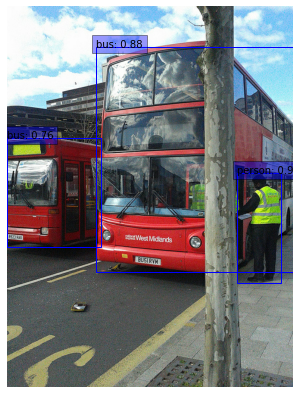

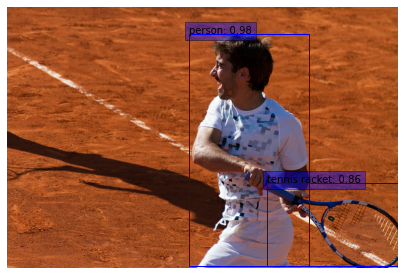

RetinaNet.call (None, None, None, 3)
N= Tensor("model_58/RetinaNet/strided_slice:0", shape=(), dtype=int32)
(None, None, None, 256)
(None, None, None, 36)
(None, None, None, 256)
(None, None, None, 36)
(None, None, None, 256)
(None, None, None, 36)
(None, None, None, 256)
(None, None, None, 36)
(None, None, None, 256)
(None, None, None, 36)
cls_outputs.shape= (None, None, 80)
box_outputs.shape= (None, None, 4)


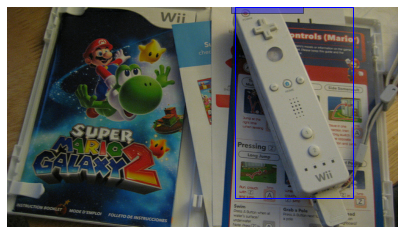

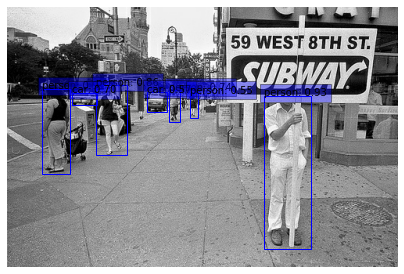

In [582]:

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio


val_dataset = tfds.load("coco/2017", split="validation", data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str

for sample in val_dataset.take(4):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )